# 🦪 Abalone

Work done in this notebook is authored by **Ian Feekes**.

You can contact me at:
* ianfeekes@gmail.com
* https://linkedin.com/in/ianfeekes

The dataset can be downloaded by the following commmand:
```bash
kaggle competitions download -c playground-series-s4e4
```

## ⚙️ General Configuration

In [387]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor

In [388]:
def rmsle(actual, pred):
    return np.sqrt(sum((np.log(1+pred) - np.log(1+actual))**2)/len(actual))

## 🔍 EDA

	Sex		nominal			M, F, and I (infant)
	Length		continuous	mm	Longest shell measurement
	Diameter	continuous	mm	perpendicular to length
	Height		continuous	mm	with meat in shell
	Whole weight	continuous	grams	whole abalone
	Shucked weight	continuous	grams	weight of meat
	Viscera weight	continuous	grams	gut weight (after bleeding)
	Shell weight	continuous	grams	after being dried
	Rings		integer			+1.5 gives the age in years

In [389]:
df = pd.read_csv('./train.csv')
df.shape

(90615, 10)

In [390]:
abalone = pd.read_csv('./abalone.data', sep=',', header=None)
abalone.columns = df.drop('id', axis=1).columns

abalone.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [391]:
df_temp = pd.concat((abalone, df.drop('id', axis=1)), axis=0)
# df_temp.shape 
df = df_temp.copy()

In [392]:
df.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


We want to predict the **Rings** of the abalone

In [393]:
target = 'Rings'

The **id** column is simply an index and doesn't have anything useful for AI/ML

In [394]:
if 'id' in df.columns:
    len(df['id'].value_counts().keys()) == len(df)

👀 Observations about dtypes:
* **Sex** will need to be encoded.
* The target variable **Rings** is an integer which means that really good models won't have as bad of error if it was a floating point variable.

In [395]:
df.dtypes

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Whole weight.1    float64
Whole weight.2    float64
Shell weight      float64
Rings               int64
dtype: object

#### 💍 Rings

There are values for the **rings** between 1 and 29 inclusive

In [396]:
len(df[target].value_counts().keys())

28

Certain values for the rings have very poor representation: very few have 1, 2, 25, 26, or 30 rings

In [397]:
# df[target].value_counts()

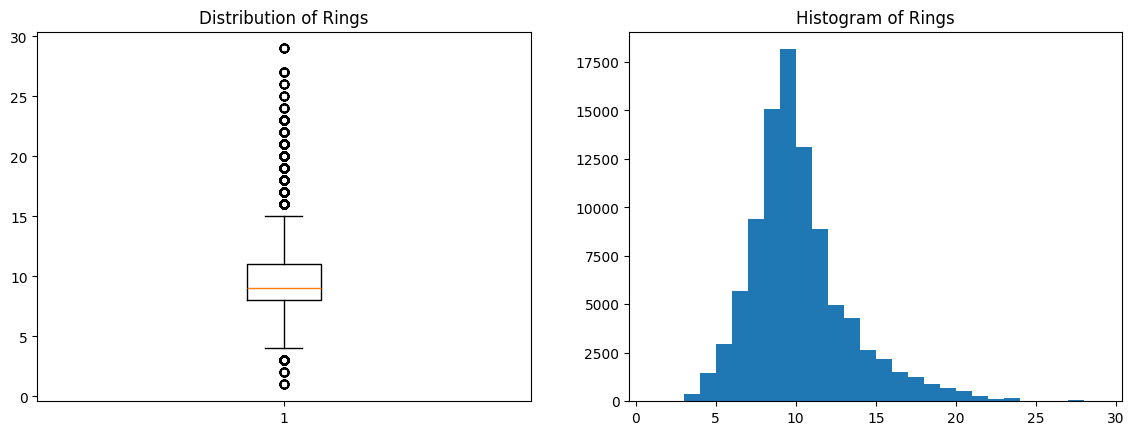

In [398]:
fig, (ax0, ax1) = plt.subplots(1, 2)
fig.set_figwidth(14)
ax0.boxplot(df['Rings'])
ax0.set_title("Distribution of Rings")
ax1.hist(df['Rings'], bins=28)
ax1.set_title("Histogram of Rings")
plt.show()

#### Length

There is a very wide distribution of length of the abalone, with many outliers of particularly small values.

We see there is a slight left-skew on the length, indicating a **Log-Transformation** or **Boxcox-Transformation** may be best for this data.

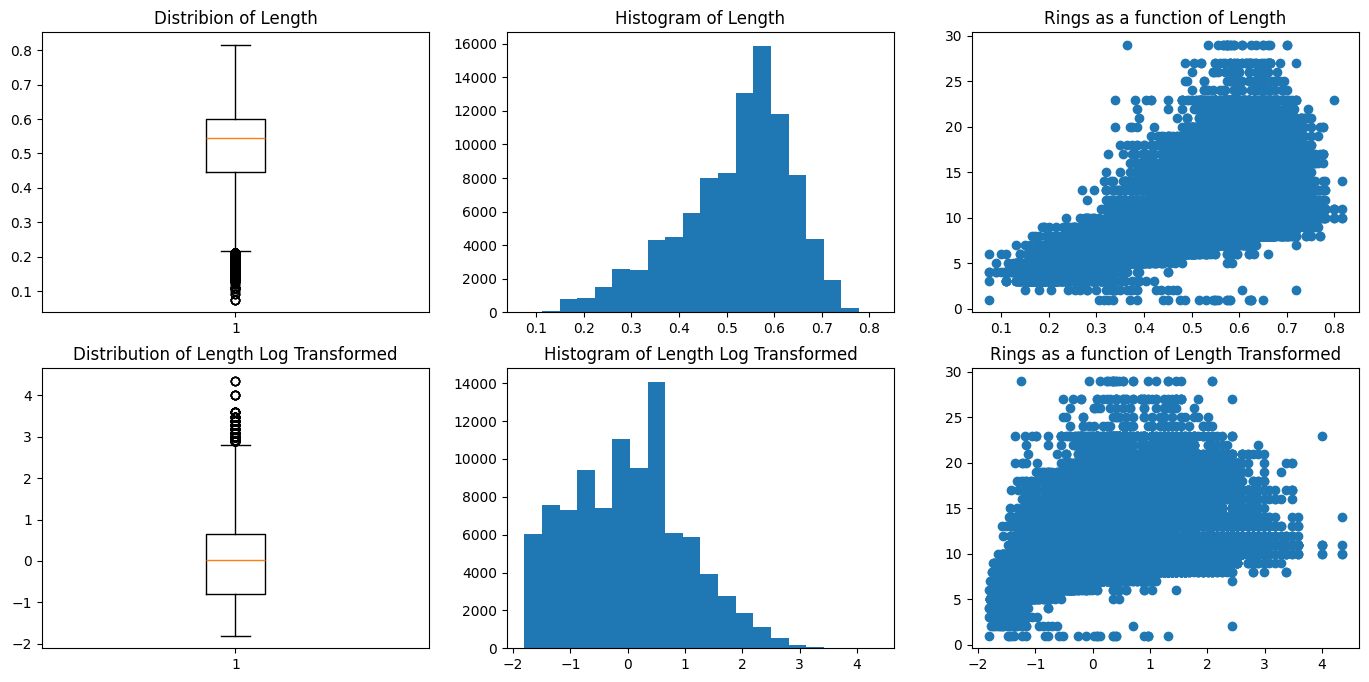

In [399]:
# df['Length_transformed'] = np.log(df['Length'])
# df['Length_transformed'] = (df['Length'] - df['Length'].mean()) / df['Length'].std()
# df['Length_transformed'] = np.sqrt(df['Length'])
# df['Length_transformed'] = 1/df['Length']   # Not good
df['Length_transformed'] = df['Length']**3  # Looks pretty good - 3 was best?
df['Length_transformed'] = (df['Length_transformed'] - df['Length_transformed'].mean()) / df['Length_transformed'].std()

fig, axes = plt.subplots(2, 3)
fig.set_figwidth(17)
fig.set_figheight(8)

ax1, ax2, ax3, ax4 = axes[0][0], axes[0][1], axes[1][0], axes[1][1]

ax1.boxplot(df['Length'])
ax1.set_title("Distribion of Length")

ax2.hist(df['Length'], bins=20)
ax2.set_title("Histogram of Length")

ax3.boxplot(df['Length_transformed'])
ax3.set_title("Distribution of Length Log Transformed")

ax4.hist(df['Length_transformed'], bins=20)
ax4.set_title("Histogram of Length Log Transformed")


ax1scatter, ax2scatter = axes[0, 2], axes[1, 2]
ax1scatter.scatter(df['Length'], df[target])
ax1scatter.set_title("Rings as a function of Length")
ax2scatter.scatter(df['Length_transformed'], df[target])
ax2scatter.set_title("Rings as a function of Length Transformed")

plt.show()

The best performance for linear regression on length was found on transformations of about ```2.85```

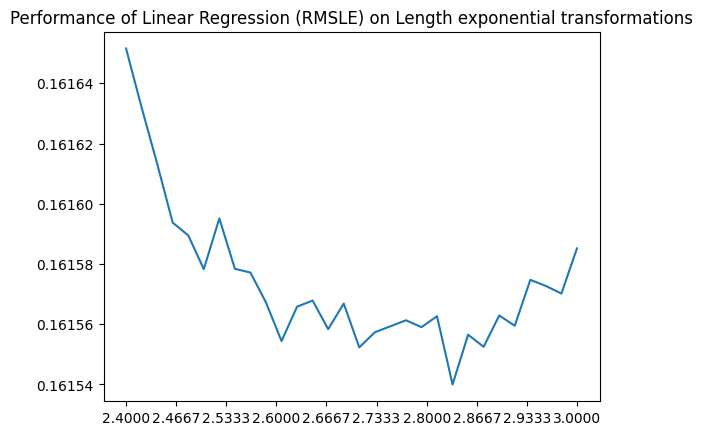

From the scatterplot we can see that there is a somewhat linear relationship between the variables, but it isn't perfect and some transformations will need to be performed.

#### Diameter

**Diameter** is really the width - measured perpendicular to length

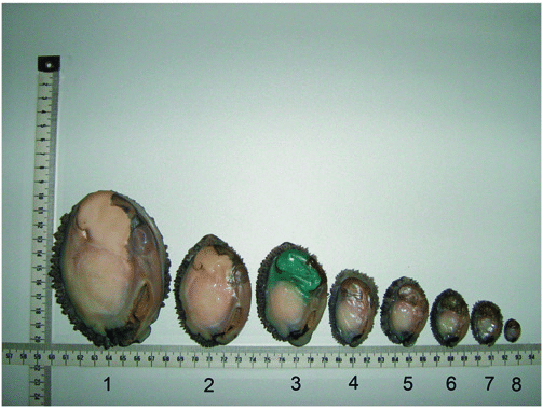

Similar to the length, there are quite a few low-value outliers here

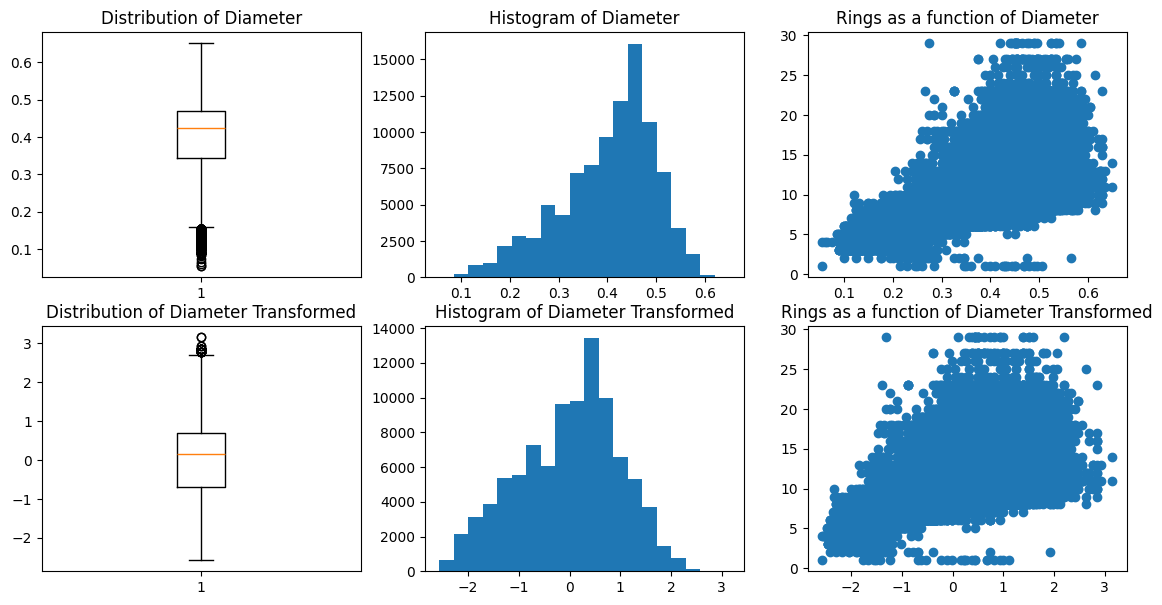

In [400]:
fig, axes = plt.subplots(2, 3)

fig.set_figwidth(14)
fig.set_figheight(7)

ax1 = axes[0][0]
ax1.boxplot(df['Diameter'])
ax1.set_title("Distribution of Diameter")

ax2 = axes[0][1]
ax2.hist(df['Diameter'], bins=20)
ax2.set_title("Histogram of Diameter")

ax3 = axes[0][2]
ax3.scatter(df['Diameter'], df[target])
ax3.set_title("Rings as a function of Diameter")

# df['Diameter_transformed'] = np.log(df['Diameter'])
# df['Diameter_transformed'] = 1 / df['Diameter']
df['Diameter_transformed'] = df['Diameter']**1.7
df['Diameter_transformed'] = (df['Diameter_transformed'] - df['Diameter_transformed'].mean()) / df['Diameter_transformed'].std()

ax4 = axes[1][0]
ax4.boxplot(df['Diameter_transformed'])
ax4.set_title("Distribution of Diameter Transformed")

ax5 = axes[1][1]
ax5.hist(df['Diameter_transformed'], bins=20)
ax5.set_title("Histogram of Diameter Transformed")

ax6 = axes[1][2]
ax6.scatter(df['Diameter_transformed'], df[target])
ax6.set_title("Rings as a function of Diameter Transformed")
plt.show()

The transformation of the diameter works best at the power of ```1.7```

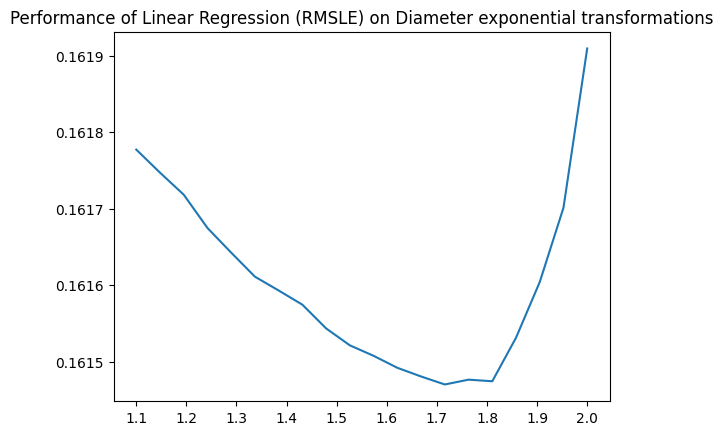

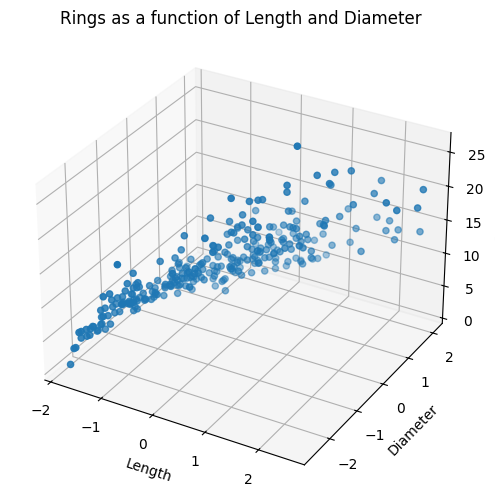

In [401]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

x = df['Length_transformed'].values[:300]
y = df['Diameter_transformed'].values[:300]
z = df['Rings'].values[:300]
scatter = ax.scatter(x, y, z)

ax.set_xlabel('Length')
ax.set_ylabel('Diameter')
ax.set_zlabel('Rings')
plt.title("Rings as a function of Length and Diameter")
plt.show()


#### Feature: Area

We just use the formula for the area of an ellipse to calculate the area:

$Area = \pi{lw}$

We can see there are fewer outliers though a bit higher variance

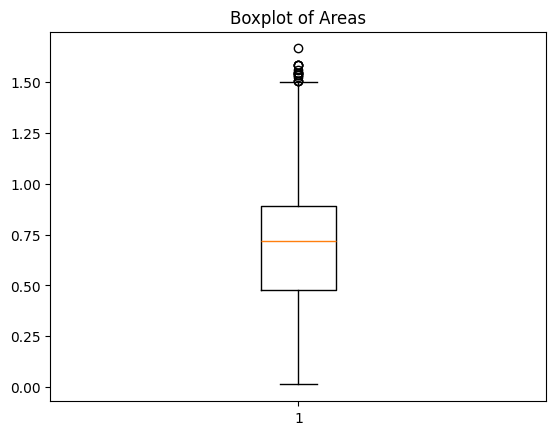

In [402]:
df['Area'] = np.pi * df['Length'] * df['Diameter']

# fig, axes = plt.subplots()
plt.boxplot(df['Area'])
plt.title("Boxplot of Areas")
plt.show()

The histogram shows less skew with a much more normal distribution

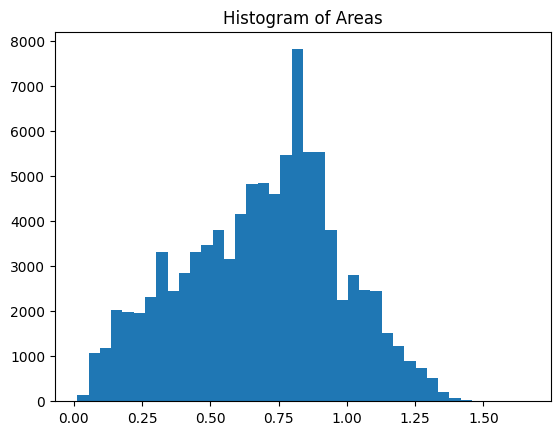

In [403]:
plt.hist(df['Area'], bins=40)
plt.title("Histogram of Areas")
plt.show()

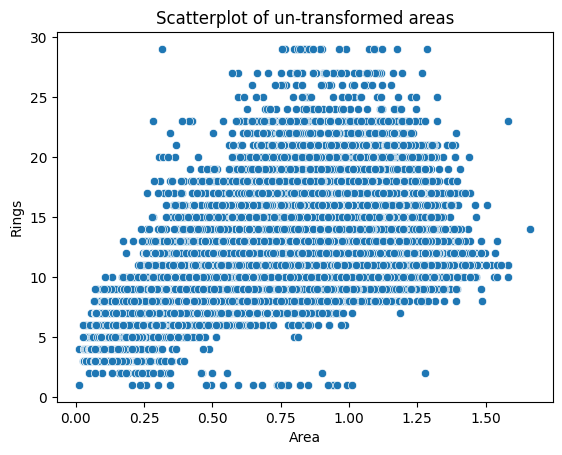

In [404]:
sns.scatterplot(data=df, x="Area", y="Rings")
plt.title("Scatterplot of un-transformed areas")
plt.show()

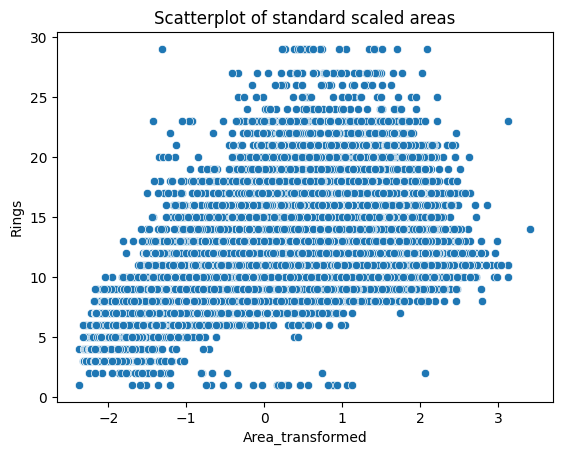

In [405]:
df['Area_transformed'] = (df['Area'] - df['Area'].mean())/ df['Area'].std()
sns.scatterplot(data=df, x='Area_transformed', y='Rings')
plt.title("Scatterplot of standard scaled areas")
plt.show()

In [406]:
df.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight', 'Rings', 'Length_transformed',
       'Diameter_transformed', 'Area', 'Area_transformed'],
      dtype='object')

#### Height

This is the height of the abalone "with meat in the shell"

There are a few outliers, but the height matches a much more normal distribution. With some standard scaling, this will be a very clean variable.

In [407]:
df['Height'].min()

0.0

We like ~```.9788``` for height

<!-- 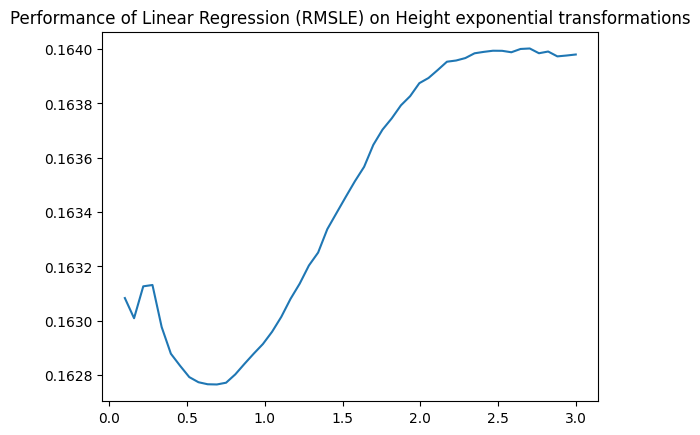 -->

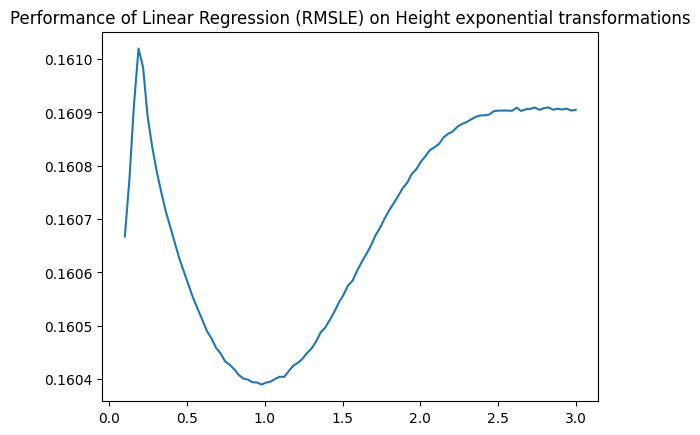

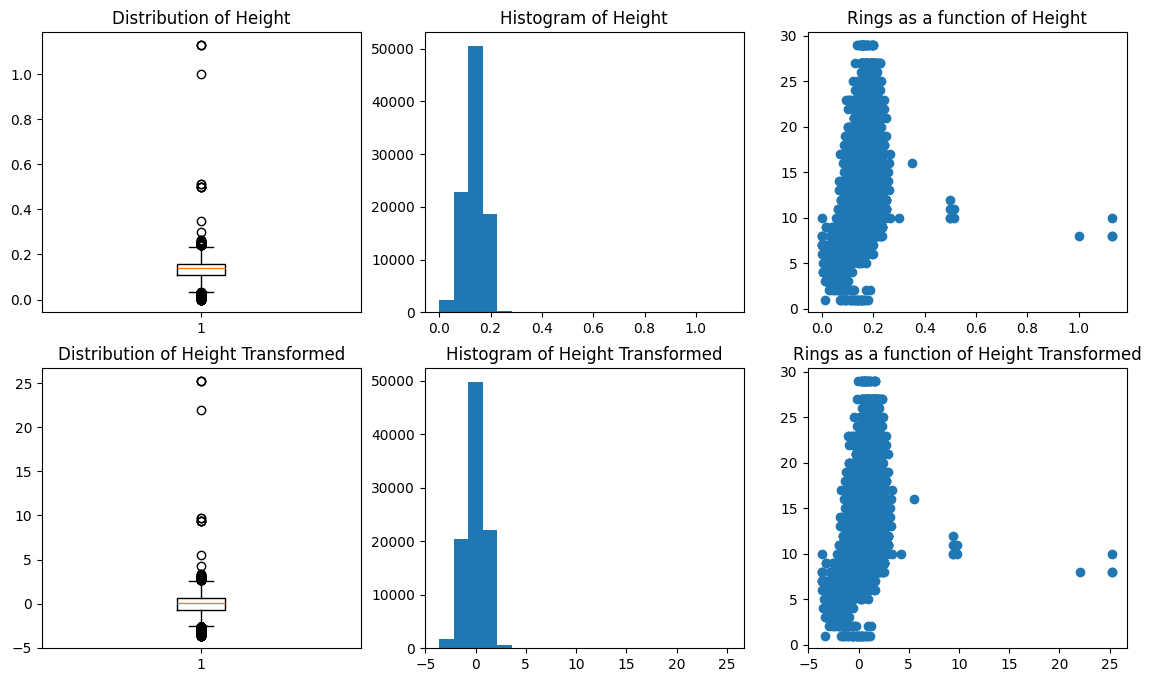

In [408]:
from scipy import stats

fig, axes = plt.subplots(2, 3)

fig.set_figwidth(14)
fig.set_figheight(8)

# df['Height_transformed'] = df['Height']**.118 #.3 looks good on the charts tho
df['Height_transformed'] = df['Height']**.9788 #.3 looks good on the charts tho
# print(df['Height_transformed'].min())
# df['Height_transformed'] = np.sqrt(df['Height'])
df['Height_transformed'] = (df['Height_transformed'] - df['Height_transformed'].mean()) / df['Height_transformed'].std()
# df['Height_transformed'] = (df['Height'] - df['Height'].mean()) / df['Height'].std()

ax1, ax2, ax3, ax4, ax5, ax6 = axes[0][0], axes[0][1], axes[0][2], axes[1][0], axes[1][1], axes[1][2]
ax1.boxplot(df['Height'])
ax1.set_title("Distribution of Height")

ax2.hist(df['Height'], bins=20)
ax2.set_title("Histogram of Height")

ax3.scatter(df['Height'], df[target])
ax3.set_title("Rings as a function of Height")

ax4.boxplot(df['Height_transformed'])
ax4.set_title("Distribution of Height Transformed")

ax5.hist(df['Height_transformed'], bins=20)
ax5.set_title("Histogram of Height Transformed")

ax6.scatter(df['Height_transformed'], df[target])
ax6.set_title("Rings as a function of Height Transformed")

plt.show()

#### Whole Weight

The **Whole Weight** is the entire weight of the abalone in grams.

From the boxplot we can see there is a bit of a right-tilt on the data, with quite a few high-weight outliers.

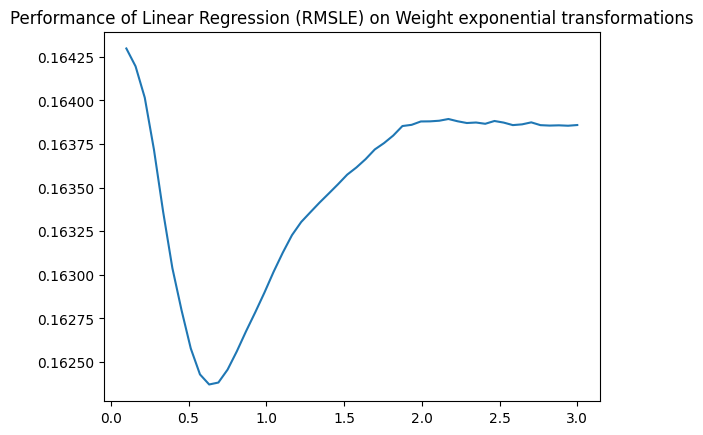

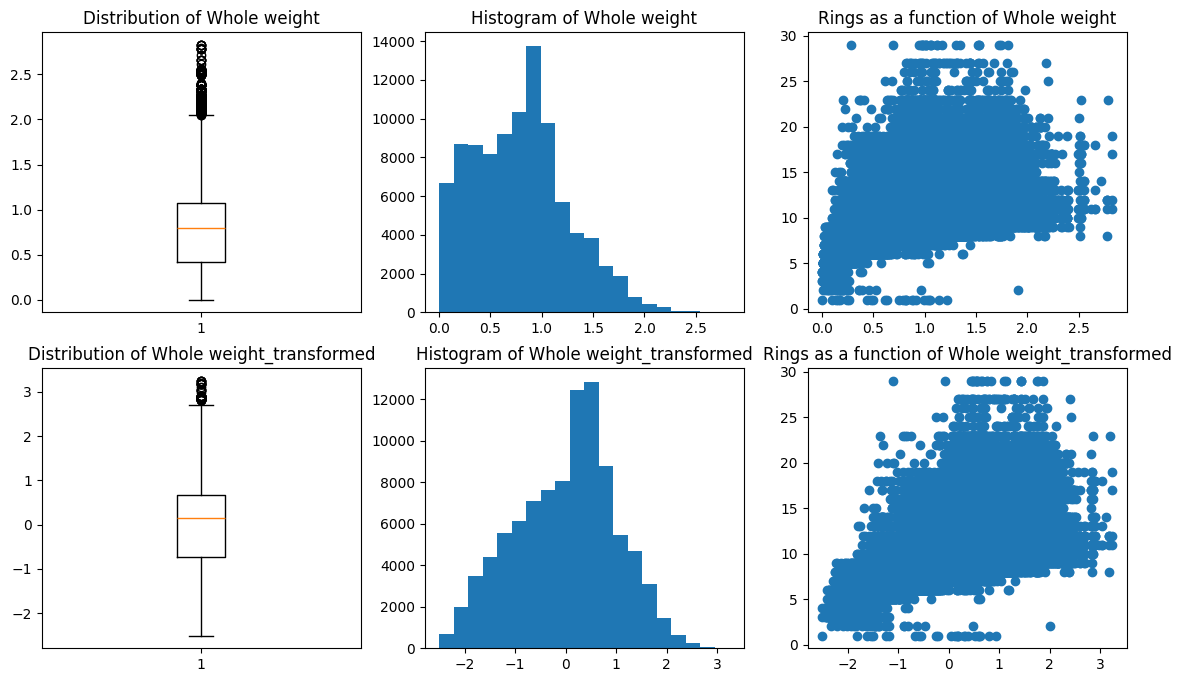

In [409]:
# df['Whole weight_transformed'] = np.sqrt(df['Whole weight'])
df['Whole weight_transformed'] = df['Whole weight']**.6
df['Whole weight_transformed'] = (df['Whole weight_transformed'] - df['Whole weight_transformed'].mean()) / df['Whole weight_transformed'].std()

def plot_continuous(df, curr_feature):
    ncols, nrows = 3, 2

    fig, axes = plt.subplots(nrows, ncols)
    fig.set_figheight(8)
    fig.set_figwidth(14)

    for i in range(nrows):
        for j in range(ncols):
            ax = axes[i][j]
            feature = curr_feature
            if i==1:
                feature = curr_feature+"_transformed"
            if j==0:
                ax.boxplot(df[feature])
                ax.set_title("Distribution of "+feature) 
            elif j==1:
                ax.hist(df[feature], bins=20)
                ax.set_title("Histogram of "+feature)
            else:
                ax.scatter(df[feature], df[target])
                ax.set_title(target+" as a function of "+feature)

    plt.show()

plot_continuous(df, 'Whole weight')

#### Shucked Weight (Whole weight.1)

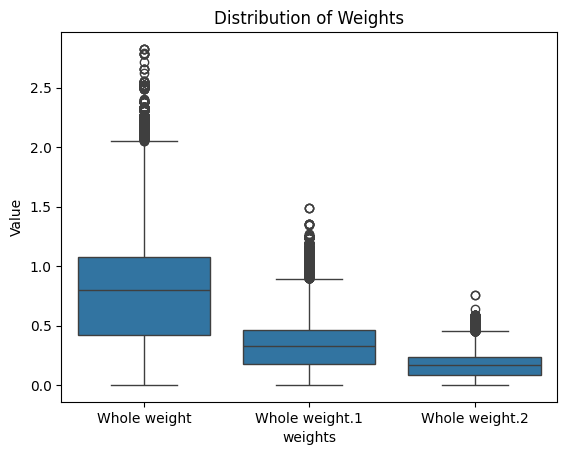

In [410]:
f, ax = plt.subplots()
df_weights = pd.melt(df[['Whole weight', 'Whole weight.1', 'Whole weight.2']], var_name="weights", value_name="Value")
sns.boxplot(x='weights', y="Value", data=df_weights, ax=ax)
plt.title("Distribution of Weights")
plt.show()

The *Shucked Weight** is best with a transform around **.```75```


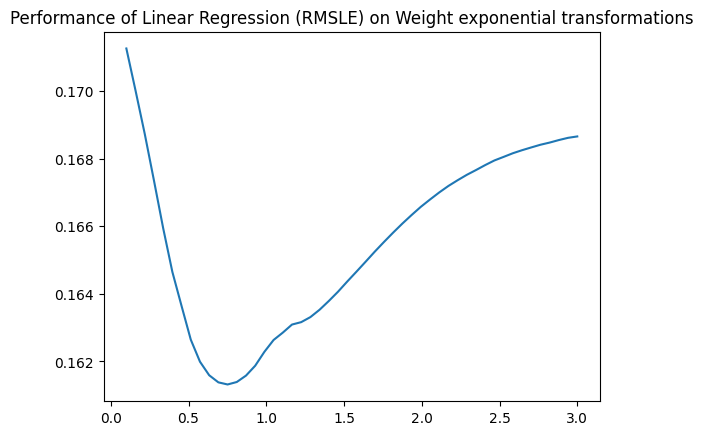

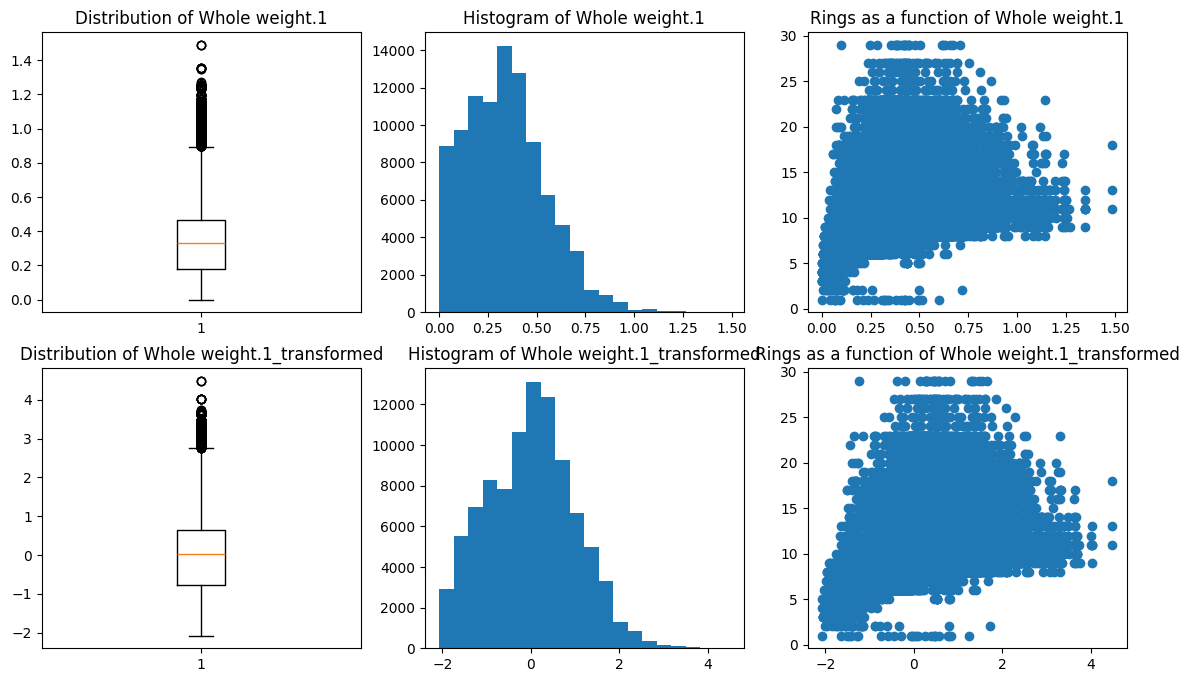

In [411]:
# df['Whole weight.1_transformed'] = np.sqrt(df['Whole weight.1'])
df['Whole weight.1_transformed'] = df['Whole weight.1']**.75
df['Whole weight.1_transformed'] = (df['Whole weight.1_transformed'] - df['Whole weight.1_transformed'].mean()) / df['Whole weight.1_transformed'].std()

plot_continuous(df, 'Whole weight.1')

In [412]:
do_pairplot = False

if do_pairplot:
    sns.pairplot(data=df)
else:
     print("Pairplot Skipped to Save Time")

Pairplot Skipped to Save Time


#### 🍖 Viscera Weight (Whole weight.2)

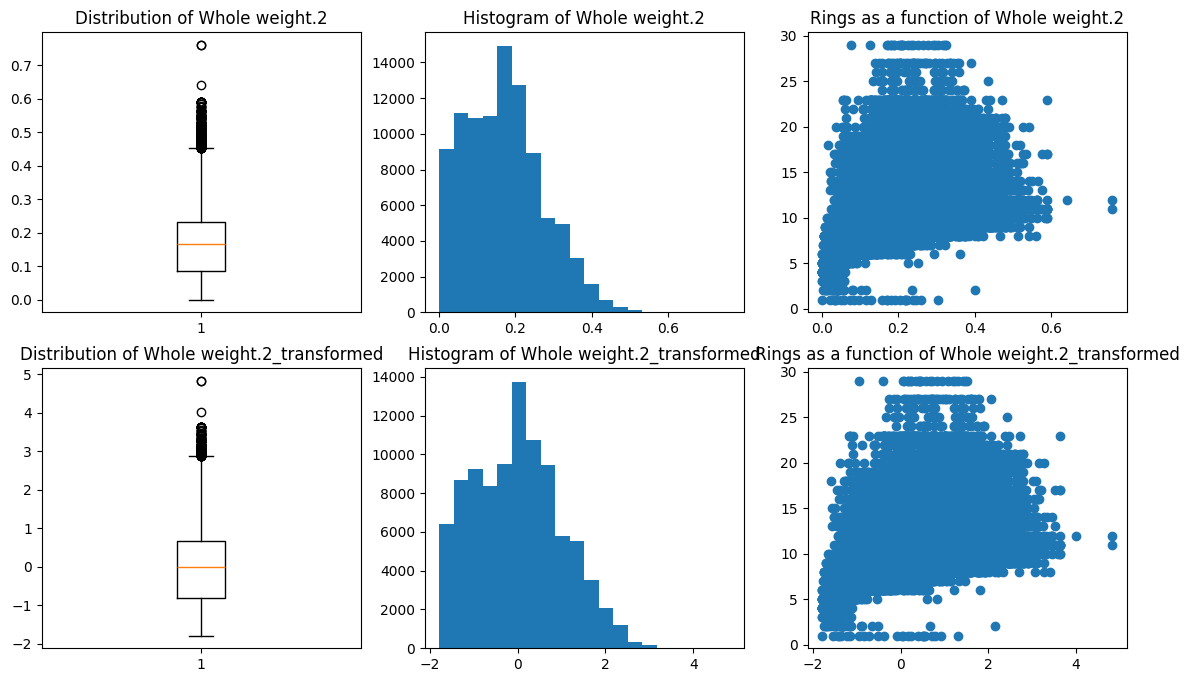

In [413]:
# df['Whole weight.2_transformed'] = df['Whole weight.2']**.75
df['Whole weight.2_transformed'] = np.log1p(df['Whole weight.2'])
df['Whole weight.2_transformed'] = (df['Whole weight.2_transformed'] - df['Whole weight.2_transformed'].mean()) / df['Whole weight.2_transformed'].std()

plot_continuous(df, 'Whole weight.2')

#### 🐚 Shell Weight

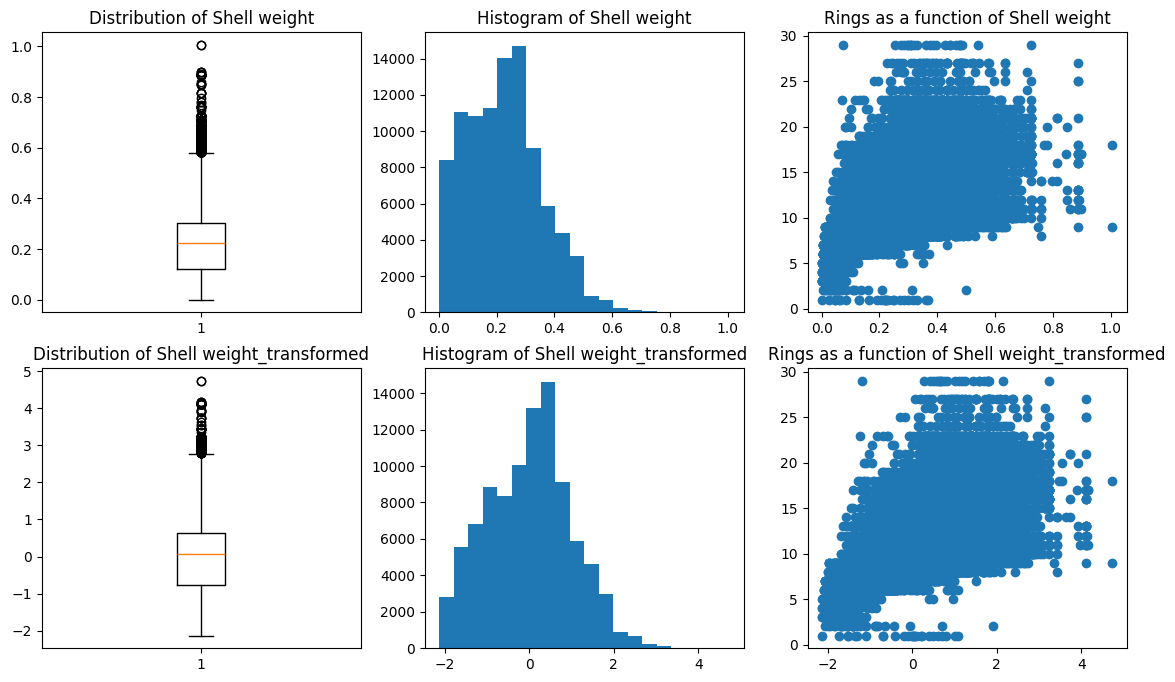

In [414]:
df['Shell weight_transformed'] = df['Shell weight']**.75
df['Shell weight_transformed'] = (df['Shell weight_transformed'] - df['Shell weight_transformed'].mean()) / df['Shell weight_transformed'].std()

plot_continuous(df, 'Shell weight')

#### ⚢ Gender

⚢ Observations about gender:
* A third gender ```I``` is encoded for infant

In [415]:
df['Sex'].value_counts()

Sex
I    34435
M    32555
F    27802
Name: count, dtype: int64

There is a relatively-even split between the genders.

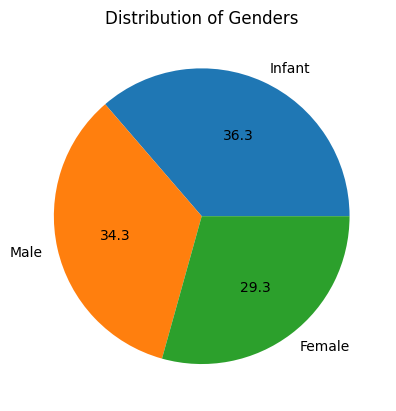

In [416]:
plt.pie(df['Sex'].value_counts(), labels=["Infant", "Male", "Female"], autopct='%0.1f')
plt.title("Distribution of Genders")
plt.show()

The ```infantile``` gender type has markedly fewer rings, which makes sense given that it would have a different age distribution.
* Both ```male``` and ```female``` tend to have about the same amount of rings.

Text(0.5, 1.0, 'Distribution of Rings by Gender')

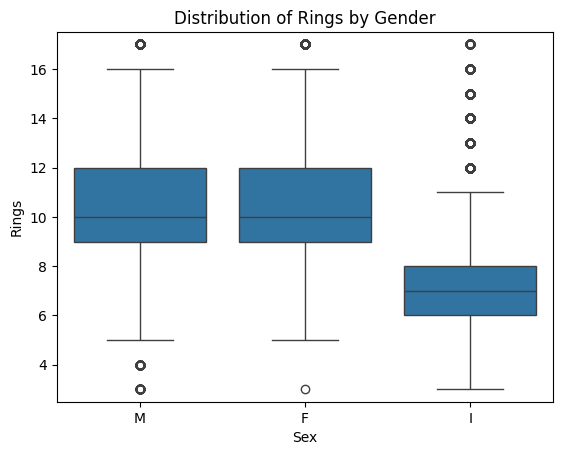

In [417]:
sns.boxplot(data=df, x='Sex', y='Rings')
plt.ylim(2.5, 17.5)
plt.title("Distribution of Rings by Gender")

## Cleaning Pipeline

In [418]:
# Encodes sex into separate columns and drops the original object-type column
def encode_sex(df):
    ret = df.copy()
    ret['Sex_I'] = ret['Sex'].apply(lambda x: 1 if x == 'I' else 0)
    ret['Sex_M'] = ret['Sex'].apply(lambda x: 1 if x == 'M' else 0)
    ret['Sex_F'] = ret['Sex'].apply(lambda x: 1 if x == 'F' else 0)
    return ret

In [419]:
# Area of ellipse is pi*l*w, then scale it for knn, kmeans algorithms
def build_area(df):
    ret = df.copy()
    ret['Area'] = np.pi * ret['Length'] * ret['Diameter']
    ret['Area_transformed'] = (ret['Area'] - ret['Area'].mean())/ret['Area'].std()
    return ret

In [420]:
power_vars = {
    'Length': 2.85,
    'Height': .9788,
    'Diameter': 1.75,
    'Whole weight': .627,
    'Whole weight.1': .6975,
    'Whole weight.2': 1.33,
    'Shell weight': .773
 }

def perform_power_transforms(df):
    ret = df.copy()
    for col in power_vars.keys():
        col_name = col+'_transformed'
        # ret[col_name] = ret[col]**power_vars[col]
        ret[col_name] = np.log1p(ret[col])
        ret[col_name] = (ret[col_name] - ret[col_name].mean()) / ret[col_name].std()
    return ret


# def transform_length(df):
#     if 'Length_transformed' not in df.columns:
#         ret = df.copy()
#         ret['Length_transformed'] = ret['Length']**2.85
#         ret['Length_transformed'] = (ret['Length_transformed'] - ret['Length_transformed'].mean()) / ret['Length_transformed'].std()
#         return ret
#     return df

In [421]:
def remove_id(df):
    return remove_col(df, 'id')

def remove_col(df, col_name):
    if col_name in df.columns:
        ret = df.copy()
        ret = ret.drop(col_name, axis=1)
        return ret
    return df

pipeline_functions = [
                      encode_sex,
                      build_area,
                      perform_power_transforms
                    #   transform_height,
                    #   transform_length,
                    #   transform_diameter,
                    #   transform_total_weight,
                    #   transform_shucked_weight,
                    #   transform_viscera_weight,
                    #   transform_shell_weight
                      ]

In [422]:
for function in pipeline_functions:
    df = function(df)

df.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Length_transformed,...,Area,Area_transformed,Height_transformed,Whole weight_transformed,Whole weight.1_transformed,Whole weight.2_transformed,Shell weight_transformed,Sex_I,Sex_M,Sex_F
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,-0.480040,...,0.521740,-0.587319,-1.068467,-0.520539,-0.532964,-0.667204,-0.559484,0,1,0
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,-1.406566,...,0.291383,-1.394088,-1.204753,-1.336890,-1.250687,-1.238816,-1.245425,0,1,0
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0.141697,...,0.699319,0.034605,-0.000067,-0.125692,-0.361010,-0.244572,-0.075651,0,0,1
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,-0.608227,...,0.504540,-0.647559,-0.263595,-0.515441,-0.582136,-0.529874,-0.518211,0,1,0
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,-1.591196,...,0.264365,-1.488711,-1.479211,-1.402031,-1.311587,-1.339674,-1.379733,1,0,0


## Feature Selection

In [423]:
# df['Height_transformed'] = np.sqrt(df['Height'])
# df['Height_transformed'] = (df['Height_transformed'] - df['Height_transformed'].mean())/df['Height_transformed'].std()

features = [
    # 'Length',
    'Length_transformed',
    # 'Diameter',
    'Diameter_transformed',
    # 'Height',
    'Height_transformed',
    # 'Whole weight',
    'Whole weight_transformed',
    # 'Whole weight.1',
    'Whole weight.1_transformed',
    # 'Whole weight.2',
    'Whole weight.2_transformed',
    # 'Shell weight',
    'Shell weight_transformed',
    # 'Area',
    'Area_transformed',
    'Sex_I',
    'Sex_M',
    'Sex_F'
]

X = df[features]
y = df[target]

## Splitting Data

In [424]:
from sklearn.model_selection import train_test_split

y_log = np.log(1 + y)

X_train, X_test, y_train, y_test = train_test_split(X, y_log, 
                                                    test_size=0.2
                                                    # test_size=0.001
                                                    )

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((75833, 11), (75833,), (18959, 11), (18959,))

## Machine Learning

### KNN

In [425]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=11)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
rmsle(y_test, knn_pred)

0.04688287542009306

#### Tuning KNN - finding best value of K

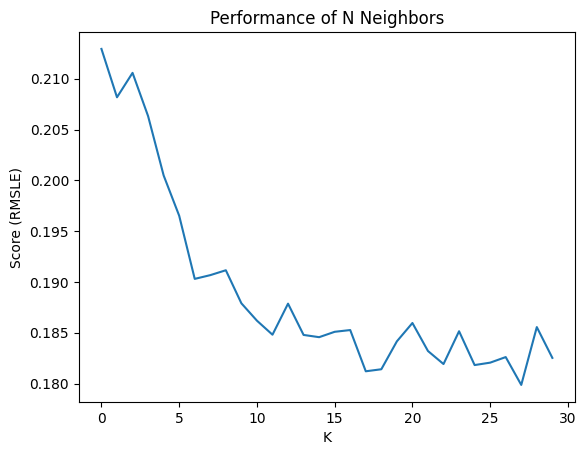

In [426]:
from sklearn.neighbors import KNeighborsClassifier

neighbors_to_test = 35
knn_folds = 5
knn_fold_scores = []

tune_n_neighbors = False

# Only run it if we want to tune - time intensive computation
if tune_n_neighbors:
    # X_temp = X[:int(len(X)*.8)]
    # y_temp = y[:int(len(y)*.8)]
    # X_temp_val = X[int(len(X)*.8):]
    # y_temp_val = y[int(len(y)*.8):]

    # Test different values of neighbors with cross validation
    for neighbor in range(neighbors_to_test):
        knn_fold_scores.append([])
        for fold in range(knn_folds):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=neighbor)
            # knn = KNeighborsClassifier(n_neighbors=neighbor+1)
            knn = KNeighborsRegressor(n_neighbors=neighbor+1)
            knn.fit(X_train, y_train)
            knn_pred = knn.predict(X_test)
            knn_fold_scores[neighbor].append(rmsle(y_test, knn_pred))

    # Collect average fold score
    knn_fold_means = []
    for arr in knn_fold_scores:
        knn_fold_means.append(np.array(arr).mean())

    # Plot the scores of each n neighbors as mean of fold
    plt.plot(range(neighbors_to_test), knn_fold_means)
    plt.title("Performance of N Neighbors")
    plt.xlabel("K")
    plt.ylabel("Score (RMSLE)")
    plt.show()

    best = 1
    best_idx = -1

    for i in range(len(knn_fold_means)):
        if knn_fold_means[i] < best:
            best = knn_fold_means[i]
            best_idx = i
    # knn_fold_means
    best, best_idx
else:
    print("KNN Tuning Skipped")

KNN Tuning Skipped


### RMSLE - competition error function

The Root Mean Squared Logarithmic Error is calculated as:

$\sqrt{1/n \sum_{i=1}^{n}(log(1+\hat{y}_{i}) - log(1+y_{i}))^{2}}$

as $RMSLE \rightarrow{0}$ the predictions become perfect

In [427]:
def rmsle(actual, pred):
    return np.sqrt(sum((np.log(1+pred) - np.log(1+actual))**2)/len(actual))

### Linear Regression

**Performance:**
<table>
<theader>
    <td>Description</td>
    <td>Performance</td>
<theader>
<tr>
    <td>Length un-manipulated </td>
    <td>.161877</td>
<tr>
<tr>
    <td>Length transformed **3.5 and scaled </td>
    <td>.161871</td>
<tr>
<tr>
    <td>Length transformed **3.5 and scaled, area removed </td>
    <td>.164004</td>
<tr>
<tr>
    <td>Length transformed **3.5 and scaled, Diameter transformed **1.7 and scaled </td>
    <td style="font-weight:bold">.161475</td>
<tr>
</table>

#### Testing K-Means Feature

Looks like K-Means for pretty much all values doesn't add anything of worth to linear regression

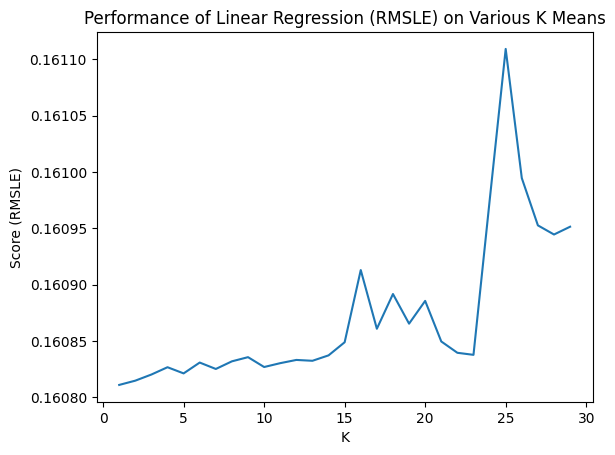

In [428]:
from sklearn.cluster import KMeans

folds = 2
rmsle_list_k_means = []
rmsle_means_k_means = []
num_clusters = 20

test_k_means = False

if test_k_means == True:
    for k in range(1, num_clusters):
        rmsle_list_k_means.append([])

        # Fit a k means on the current value for k
        kmeans = KMeans(k)
        kmeans.fit(X)
        X_new = X.copy()
        kmeans_df = pd.get_dummies(kmeans.labels_)
        for col in kmeans_df.columns:
            X_new[str(col)] = kmeans_df[col].copy()

        for fold in range(folds):
            X_train_fold, X_test_fold, y_train_fold, y_test_fold = train_test_split(X_new, y, test_size=0.2, random_state=fold)

            gbr = GradientBoostingRegressor(n_estimators=450, learning_rate=0.1, max_depth=5, random_state=42)

            # lr = LinearRegression()
            # lr.fit(X_train_fold, y_train_fold)
            gbr.fit(X_train_fold, y_train_fold)
            # lr_pred_fold = abs(lr.predict(X_test_fold))
            lr_pred_fold = abs(gbr.predict(X_test_fold))
            rmsle_list_k_means[-1].append(rmsle(y_test_fold, lr_pred_fold))

        rmsle_means_k_means.append(np.array(rmsle_list_k_means[-1]).mean())
        
    plt.plot(range(1, num_clusters), rmsle_means_k_means)
    plt.title("Performance of Linear Regression (RMSLE) on Various K Means")
    plt.xlabel("K")
    plt.ylabel("Score (RMSLE)")
else:
    print("K Means Testing Skipped")

K Means Testing Skipped


Likewise, the GBR seems not to gain anything from adding K-means labels

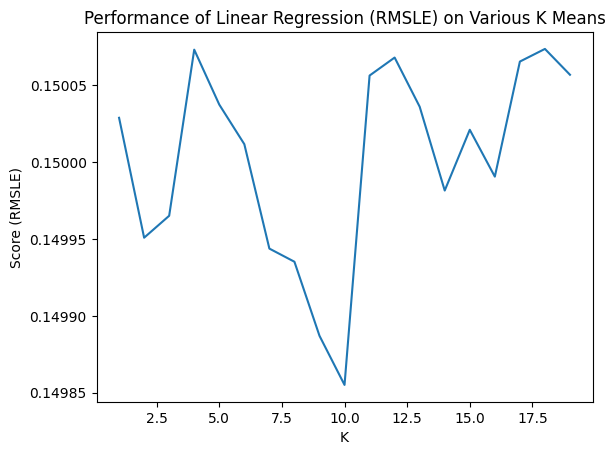

#### Testing Data Transformations

In [429]:
transforms = np.linspace(.1, 3, 100)
folds = 10
rmsle_list = []

test_transform = False
col_of_interest = 'Height'

if test_transform == True:
    for transform in range(len(transforms)):
        # Apply the desired transform and scale it
        df[col_of_interest+'_transformed'] = df[col_of_interest]**transforms[transform]
        df[col_of_interest+'_transformed'] = (df[col_of_interest+'_transformed'] - df[col_of_interest+'_transformed'].mean()) / df[col_of_interest+'_transformed'].std()

        X = df[features]
        rmsle_list.append([])

        for fold in range(folds):
            X_train_fold, X_test_fold, y_train_fold, y_test_fold = train_test_split(X, y, test_size=0.2, random_state=fold)
            lr = LinearRegression()
            lr.fit(X_train_fold, y_train_fold)
            lr_pred = abs(lr.predict(X_test_fold))
            rmsle_list[transform].append(rmsle(y_test_fold, lr_pred))

    rmsle_means = []
    for i in rmsle_list:
        rmsle_means.append(np.array(i).mean())

    # Show the different data transforms
    plt.plot(transforms, rmsle_means)
    # plt.xticks(np.linspace(, 3, 10))
    plt.title("Performance of Linear Regression (RMSLE) on Height exponential transformations")
    plt.show()
else:
    print("Data transformations with Linear Regression performance testing skipped")

Data transformations with Linear Regression performance testing skipped


In [430]:
if test_transform == True:
    # RMSLE can't go above 1
    best = 1
    best_idx = -1

    # Find the best score for the best transformation
    for i in range(len(rmsle_means)):
        if rmsle_means[i] < best:
            best = rmsle_means[i]
            best_idx = i

    print(best, transforms[best_idx])

scale 0.16153925291668622

sqrt 0.1619147880486632

sqrt + scale 0.16191397354800663

.118 + scale 0.16229501509014949

.3 + scale 0.1623792294674305

Full trainig data, no transformations on height: 0.16297096040264622

Full training data, no transformations on height, weight set to **.6 0.16241799401763996

Full training data, no transformations on height, shucked weight set to **.75 0.16108212081375844

viscera weight sent to 1.33 0.16119257277686044

shell weight sent to .773 0.16091756364994345

diameter optimized 0.16092034750199696

height optimized 0.16047796130865938

In [431]:
folds = 30
root_mean_squared_logarithmic_errors = []

for fold in range(folds):
    # Split the data for the current fold, using the index as the random state
    X_train_fold, X_test_fold, y_train_fold, y_test_fold = train_test_split(X, y,
        test_size=0.2,
        random_state=fold)

    # Fit a new Linear Regression model on the data - shouldn't take too long
    lr = LinearRegression()
    lr.fit(X_train_fold, y_train_fold)

    # Get predictins for the current fold: absolute value because sometimes linear regression will return -1
    lr_pred = abs(lr.predict(X_test_fold))

    # Add the current errors
    root_mean_squared_logarithmic_errors.append(rmsle(y_test_fold, lr_pred))

np.array(root_mean_squared_logarithmic_errors).mean()

0.16007215872034244

#### Evaluating Linear Regression

In [432]:
lr = LinearRegression()
lr.fit(X_train, y_train)
# lr.fit(X, y)

lr_pred = lr.predict(X_test)
# lr_pred = np.round(lr_pred)
lr_pred = abs(lr_pred)
rmsle(y_test, lr_pred)

0.04710265356280912

We can see how our predictions fair against the true labels graphically below

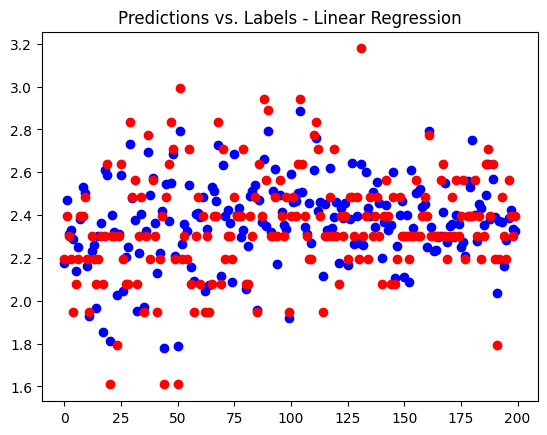

In [433]:
num_preds = 200
num_preds = min(len(y_test), num_preds)

plt.plot(range(num_preds), lr_pred[:num_preds], 'bo')
plt.plot(range(num_preds), y_test[:num_preds], 'ro')
plt.title("Predictions vs. Labels - Linear Regression")
plt.show()

### GBR

In [469]:
gbr = GradientBoostingRegressor(n_estimators=550, learning_rate=0.1, max_depth=5, random_state=42)
# {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 550}

gbr.fit(X, np.log(1+y))
# gbr.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=550, random_state=42)

##### GBR Hyperparameter Tuning

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300} 0.6613317228847981

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 350} 0.6616704779668907

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400} 0.6620286700549894

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 450} 0.6619081886497342

In [435]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

perform_gbr_tuning = False

param_grid = {
    # 'n_estimators': [10, 50, 100, 200, 300],
    'n_estimators': [10, 50, 100, 200, 300, 400, 425, 450, 475, 500, 525, 550, 575],
    'learning_rate': [0.01, 0.1, 0.2],
    # , 0.1, 0.2],
    # 'max_depth': [3, 4, 5, 6, 7]
    'max_depth': [3,4, 5, 6, 7]
}


if perform_gbr_tuning == True:
    gbr = GradientBoostingRegressor()
    # Set up the grid search
    grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    best_parameters = grid_search.best_params_
    best_score = grid_search.best_score_

    print(best_parameters, best_score)
else:
    print("GBR Hyperparameter Tuning Skipped")

GBR Hyperparameter Tuning Skipped


##### GBR Evaluation

baseline: ~ 0.15076371142250888


0.14960600094969792

0.1497506403055645

In [486]:
y_pred_gbr = gbr.predict(X_test)
rmsle(np.exp(y_test) + 1, np.exp(y_pred_gbr) + 1)

0.11370759575767456

### ANN

In [437]:
# !pip3 install tensorflow
# !pip3 install keras

from tensorflow import keras
from keras.optimizers import Adam, RMSprop, SGD
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError

model = keras.Sequential([
    keras.layers.Dense(128, activation='relu'), 
    keras.layers.Dropout(rate=0.1),
    keras.layers.Dense(64, activation='relu'), 
    keras.layers.Dropout(rate=0.1),
    keras.layers.Dense(64, activation='relu'), 
    keras.layers.Dropout(rate=0.1),
    # keras.layers.Dense(32, activation='relu'), 
    # keras.layers.Dropout(rate=0.1),
    # keras.layers.Dense(16, activation='relu'), 
    # keras.layers.Dropout(rate=0.1),
    keras.layers.Dense(1)  
])

model.compile(optimizer=Adam(), loss='mse', metrics=[RootMeanSquaredError(), MeanAbsoluteError()])


history = model.fit(X_train, y_train,batch_size=64,epochs=50,verbose=1)

nn_pred = model.predict(X_test)
nn_pred

Epoch 1/50


1185/1185 ━━━━━━━━━━━━━━━━━━━━ 1s 474us/step - loss: 0.4016 - mean_absolute_error: 0.3953 - root_mean_squared_error: 0.5652
Epoch 2/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 1s 468us/step - loss: 0.0519 - mean_absolute_error: 0.1767 - root_mean_squared_error: 0.2278
Epoch 3/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 0.0444 - mean_absolute_error: 0.1617 - root_mean_squared_error: 0.2106
Epoch 4/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 1s 469us/step - loss: 0.0403 - mean_absolute_error: 0.1539 - root_mean_squared_error: 0.2007
Epoch 5/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step - loss: 0.0368 - mean_absolute_error: 0.1456 - root_mean_squared_error: 0.1919
Epoch 6/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - loss: 0.0335 - mean_absolute_error: 0.1390 - root_mean_squared_error: 0.1830
Epoch 7/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step - loss: 0.0314 - mean_absolute_error: 0.1328 - root_mean_squared_error: 0.1773
Epoch 8/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 0.

array([[2.1522017],
       [2.5691721],
       [2.2932167],
       ...,
       [2.444529 ],
       [2.480454 ],
       [1.925645 ]], dtype=float32)

In [461]:
nn_pred_flat = []
for i in nn_pred:
    nn_pred_flat.append(i[0])

nn_pred_flat = np.array(nn_pred_flat)
rmsle(np.exp(y_test) - 1, np.exp(nn_pred_flat) -1)

0.1525091366045523

## Reading Test DF, Submission Prep

### Looking at Sample Data

If you want to look at the sample submission you can uncomment the below block. It just wants a column for ```id``` of integer type and a column for ```rings``` of integer type

In [439]:
# df_sample = pd.read_csv('./sample_submission.csv')
# df_sample.head()

### Reading Test Data

In [440]:
df_test = pd.read_csv('./test.csv')
df_test.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


Run the cleaning pipeline on the testing data

### 🫧 Preparing/Cleaning Test Data

In [441]:
df_test_clean = df_test.copy()

for function in pipeline_functions:
    df_test_clean = function(df_test_clean)

df_test_clean.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Sex_I,...,Sex_F,Area,Area_transformed,Length_transformed,Height_transformed,Diameter_transformed,Whole weight_transformed,Whole weight.1_transformed,Whole weight.2_transformed,Shell weight_transformed
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005,0,...,0,0.962505,0.963893,1.043654,0.518081,0.743919,0.992554,1.333454,1.400384,0.615791
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750,0,...,0,0.838177,0.525653,0.541996,0.646932,0.601254,0.523929,0.727781,0.536030,0.426428
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405,0,...,0,0.738903,0.175725,0.383481,0.128156,0.213528,0.232938,0.131469,0.193546,0.164112
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350,0,...,0,0.877447,0.664074,0.462991,0.258698,0.885140,0.304919,0.131469,0.213387,0.121620
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050,1,...,0,0.423722,-0.935241,-0.830438,-0.667328,-0.752931,-0.942697,-0.910829,-1.035131,-0.941977


### 🤔 Predicting Test Data

In [487]:
# test_preds = np.round(gbr.predict(df_test_clean[features]))
test_preds = np.exp(gbr.predict(df_test_clean[features])) -  1
# test_preds = model.predict(df_test_clean[features])
# test_preds = lr.predict(df_test_clean[features])
# test_preds = np.round(gbr.predict(df_test_clean[features]))

# Unweighted average
# test_preds = np.round(lr.predict(df_test_clean[features]) + gbr.predict(df_test_clean[features]) / 2)

test_preds

array([ 9.78880417,  9.4211497 , 10.02226056, ..., 12.03884021,
       12.0922667 ,  7.99046444])

## ✅ Making Submissions

Here we create a new submission dataframe with the **id** values from the testing dataframe, and the **rings** from our ML predictions.

In [488]:
df_submit = pd.DataFrame()
df_submit['id'] = df_test['id']
df_submit['Rings'] = test_preds
df_submit.head()

,id,Rings
0,90615,9.788804
1,90616,9.421150
2,90617,10.022261
3,90618,10.530373
4,90619,7.465676


Just some final flight-checks here:
* Make sure the **rings** values are positive (which may not necessarily be true for some models e.g. Linear Regression)
* Cast the **rings** as integer type
* Make sure the submission will follow the constraints of the Kaggle submission checker

In [490]:
df_submit['Rings'] = abs(df_submit['Rings'])
# df_submit['Rings'] = df_submit['Rings'].astype(int)

assert(df_submit['Rings'].min() >=0)
assert(len(df_submit)==60411)

In [493]:
df_submit['Rings'] = df_submit['Rings'] + 1

Save the dataframe into a local directory as ```submission.csv``` - make sure it does **not** have an index

In [494]:
df_submit.to_csv('./submission.csv', index=False)

Submit to kaggle (will need to have *kaggle.json* file configured in your ~./kaggle/kaggle.json directory and added to path)

In [495]:
# !kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Just added 1 to all predictions in the previous submission"

100%|██████████████████████████████████████| 1.46M/1.46M [00:01<00:00, 1.02MB/s]
400 - Bad Request - Submission not allowed:  Your team has used its daily Submission allowance (5) today, please try again tomorrow UTC (16 hours from now).
